In [0]:
!pip install lda

Pre process + LDA topic analysis

In [0]:
import nltk
from nltk.corpus import stopwords
from nltk import tokenize as tok
from nltk.stem.snowball import SnowballStemmer # load nltk's SnowballStemmer as variabled 'stemmer'
import lda # topic modeling -NMF & LDA
import string
from nltk.tag import StanfordNERTagger
import re
import pickle

import numpy as np
import pandas as pd

In [0]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Tf-Idf and Clustering packages
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [0]:
#remove unnessary words
#Complie all regular expressions
isURL = re.compile(r'http[s]?:// (?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', re.VERBOSE | re.IGNORECASE)
isRTusername = re.compile(r'^RT+[\s]+(@[\w_]+:)',re.VERBOSE | re.IGNORECASE) #r'^RT+[\s]+(@[\w_]+:)'
isEntity = re.compile(r'@[\w_]+', re.VERBOSE | re.IGNORECASE)

In [0]:
# Helper functions

# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
     
        
def clean_tweet(row):
    row = isURL.sub("",row)
    row = isRTusername.sub("",row)
    row = isEntity.sub("",row)
    return row

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in tok.sent_tokenize(text) for word in tok.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [0]:
tweet_df_comp = pickle.load( open( "tweets_df.txt", "rb" ) )
event_df_comp = pickle.load( open( "events_tweet_df.txt", "rb"))

In [0]:
event_df_comp['tweet'].head()

8     FOUR IN A ROW!!\nThe Dublin Senior GAA Footbal...
11    Eid Fest in Herbert Park in Ballsbridge is a f...
47    On Sunday afternoon (15:00-20:00) the world mu...
55    Lots of events happening today! And the weathe...
56    Dublin Maker is a day-long festival for hacker...
Name: tweet, dtype: object

In [0]:
 # remove urls and retweets and entities from the text
tweet_df_comp['text_clean'] = tweet_df_comp['tweet'].apply(lambda row:clean_tweet(row))
event_df_comp['text_clean'] = event_df_comp['tweet'].apply(lambda row:clean_tweet(row))
#remove punctuations
RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation])  
tweet_df_comp['text_clean'] = tweet_df_comp['text_clean'].str.replace(RE_PUNCTUATION, "")
event_df_comp['text_clean'] = event_df_comp['text_clean'].str.replace(RE_PUNCTUATION, "")
event_df_comp.head()

,tweet,coordinates,true_date,text_clean
8,FOUR IN A ROW!!\nThe Dublin Senior GAA Footbal...,"[(53.3471212, -6.2756149)]",2018-09-03,FOUR IN A ROW\nThe Dublin Senior GAA Football ...
11,Eid Fest in Herbert Park in Ballsbridge is a f...,"[(53.3276869, -6.23656997033567)]",2018-09-01,Eid Fest in Herbert Park in Ballsbridge is a f...
47,On Sunday afternoon (15:00-20:00) the world mu...,"[(53.3471212, -6.2756149)]",2018-07-29,On Sunday afternoon 15002000 the world music f...
55,Lots of events happening today! And the weathe...,"[(53.3385656, -6.2435878)]",2018-07-21,Lots of events happening today And the weather...
56,Dublin Maker is a day-long festival for hacker...,"[(53.3385656, -6.2435878)]",2018-07-21,Dublin Maker is a daylong festival for hackers...


In [0]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
stop_list= stopwords.words('english') #import stopwords from NLTK package
stop_list.append('http')
stop_list.append('https')

In [0]:
corpus = tweet_df_comp['text_clean'].tolist()
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=0.00, stop_words=stop_list, tokenizer=tokenize_only) # Use tf (raw term count) features for LDA.
tf = tf_vectorizer.fit_transform(corpus)
corpus[:5]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


['DUBLIN Breakdown cleared on St Johns Rd West More here  \xa0',
 'DUBLIN Breakdown on St Johns Rd West More here  \xa0',
 'DUBLIN Incident cleared from the M50 southbound More here  \xa0',
 'DUBLIN No further reports of a collision on M1 northbound More here  \xa0',
 'DUBLIN Reports of a collision on M1 northbound More here  \xa0']

In [0]:
event_corpus = event_df_comp['text_clean'].tolist()
tf_event_vectorizer = CountVectorizer(max_df=0.9, min_df=0.00, stop_words=stop_list, tokenizer=tokenize_only) # Use tf (raw term count) features for LDA.
tf_event = tf_event_vectorizer.fit_transform(event_corpus)
event_corpus[:5]


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


['FOUR IN A ROW\nThe Dublin Senior GAA Football Team won the All Ireland Senior title for the fourth time in a row yesterday and there will be a big celebration today from 1830 on Smithfield Plaza with and for  \xa0…',
 'Eid Fest in Herbert Park in Ballsbridge is a festival organised by the muslim community for ALL communities in Dublin Eid means celebration in Arabic \nThere will be a BBQ and other food stalls a market and lots of Inflatable Games for kids and  \xa0…',
 'On Sunday afternoon 15002000 the world music festival Hotter Than July will happen at Smithfield Plaza \n\nThe five hours will be filled with music from all over the gaff \n with Samba Drumming  \xa0…',
 'Lots of events happening today And the weather is also holding up so go to Merrion Square for the Dublin Maker Fair or to Wolftone Square for the Playground of Sound and then there is the Liberties  \xa0…',
 'Dublin Maker is a daylong festival for hackers crafters coders DIYers curious inventors AND every curious per

In [0]:
# Create and fit the LDA model
model = LDA(n_components=4, n_jobs=-1)
id_topic = model.fit(tf)
event_model = LDA(n_components=4, n_jobs=-1)
event_topic = event_model.fit(tf_event)

In [0]:
print("Topics found via LDA:")
topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=model, n_words=3)  
df_topic_keywords  = pd.DataFrame(topic_keywords)
df_topic_keywords .columns = ['Word '+str(i) for i in range(df_topic_keywords .shape[1])]
df_topic_keywords .index = ['Topic '+str(i) for i in range(df_topic_keywords .shape[0])]
df_topic_keywords  = df_topic_keywords.reset_index()
df_topic_keywords ['topic_index'] = df_topic_keywords['index'].str.split(' ', n = 1, expand = True)[[1]].astype('int')
print(df_topic_keywords)

Topics found via LDA:
     index  Word 0   Word 1      Word 2  topic_index
0  Topic 0      rd   dublin     traffic            0
1  Topic 1  dublin       st        lane            1
2  Topic 2  dublin      m50  northbound            2
3  Topic 3      rd  kildare  southbound            3


In [0]:
print("Event topics found via LDA:")
event_topic_keywords = show_topics(vectorizer=tf_event_vectorizer, lda_model=event_model, n_words=3)  
df_event_topic_keywords  = pd.DataFrame(event_topic_keywords)
df_event_topic_keywords .columns = ['Word '+str(i) for i in range(df_event_topic_keywords .shape[1])]
df_event_topic_keywords .index = ['Topic '+str(i) for i in range(df_event_topic_keywords .shape[0])]
df_event_topic_keywords  = df_event_topic_keywords.reset_index()
df_event_topic_keywords ['topic_index'] = df_event_topic_keywords['index'].str.split(' ', n = 1, expand = True)[[1]].astype('int')
print(df_event_topic_keywords)

Event topics found via LDA:
     index  Word 0   Word 1  Word 2  topic_index
0  Topic 0  square  merrion  dublin            0
1  Topic 1  dublin     park     new            1
2  Topic 2  dublin   street  garden            2
3  Topic 3    park   street  dublin            3


Sentiment Analysis

In [0]:
import keras
import h5py
from keras.models import model_from_json
from keras.models import load_model
import json
from nltk.tokenize import RegexpTokenizer

Using TensorFlow backend.


In [0]:
 # read in the weight of the trained model.

prd_model = load_model("/content/models_dl_sentiment_model_best_weight_glove_bi_512.hdf5")
prd_model.summary()
word_idx = json.load(open("/content/models_dl_sentiment_model_word_idx.txt"))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 56, 300)           120000300 
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_20 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                5130      
Total params: 120,576,310
Tra

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
def get_sentiment_DL(prd_model, text_data, word_idx):

    #data = "Pass the salt"

    live_list = []
    batchSize = len(text_data)
    live_list_np = np.zeros((56,batchSize))
    for index, row in text_data.iterrows():
        #print (index)
        text_data_sample = text_data['tweet'][index]
        # split the sentence into its words and remove any punctuations.
        tokenizer = RegexpTokenizer(r'\w+')
        text_data_list = tokenizer.tokenize(text_data_sample)

        #text_data_list = text_data_sample.split()


        labels = np.array(['1','2','3','4','5','6','7','8','9','10'], dtype = "int")
        #word_idx['I']
        # get index for the live stage
        data_index = np.array([word_idx[word.lower()] if word.lower() in word_idx else 0 for word in text_data_list])
        data_index_np = np.array(data_index)

        # padded with zeros of length 56 i.e maximum length
        padded_array = np.zeros(56)
        padded_array[:data_index_np.shape[0]] = data_index_np[:56]
        data_index_np_pad = padded_array.astype(int)


        live_list.append(data_index_np_pad)

    live_list_np = np.asarray(live_list)
    score = prd_model.predict(live_list_np, batch_size=batchSize, verbose=0)
    single_score = np.round(np.dot(score, labels)/10,decimals=2)

    score_all  = []
    for each_score in score:

        top_3_index = np.argsort(each_score)[-3:]
        top_3_scores = each_score[top_3_index]
        top_3_weights = top_3_scores/np.sum(top_3_scores)
        single_score_dot = np.round(np.dot(top_3_index, top_3_weights)/10, decimals = 2)
        score_all.append(single_score_dot)

    text_data['Sentiment_Score'] = pd.DataFrame(score_all)

    return text_data

In [0]:
# Deep Learning sentiment scoring
tweet_out = get_sentiment_DL(prd_model, tweet_df_comp, word_idx)
event_df_comp['tweet'] = [x.replace("\n"," ") for x in event_df_comp['tweet']]
event_df_comp['tweet'] = [x.replace("\t"," ") for x in event_df_comp['tweet']]
event_df_comp['tweet'] = [x.replace("’","") for x in event_df_comp['tweet']]  
event_df_comp.drop(55, inplace=True)
event_df_comp.drop(317, inplace=True)
event_df_comp.drop(45, inplace=True)
event_df_comp.drop(47, inplace=True)
event_df_comp.drop(62, inplace=True)
event_df_comp.drop(7, inplace=True)
event_out = get_sentiment_DL(prd_model, event_df_comp, word_idx)

In [0]:
tweet_out.sort_values(by='Sentiment_Score')[['tweet','Sentiment_Score']].head().T

,5234,5235,215,5046,356
tweet,#WESTMEATH #LONGFORD: Debris cleared from N6 D...,#WESTMEATH Debris on #N6 Dublin/Galway Rd betw...,#DUBLIN One lane of southbound bore of the Por...,#DUBLIN Debris outbound on N7 Naas Rd at Newla...,"Hi Mark, full details of road closures and res..."
Sentiment_Score,0.07,0.1,0.1,0.1,0.11


In [0]:
tweet_out['tweet'].loc[8341]

'Hi Denise, the M7 Dublin/Limerick Rd is now moving well in both directions.'

In [0]:
tweet_out['tweet'].loc[5235]

'#WESTMEATH Debris on #N6 Dublin/Galway Rd between J9 Garrycastle & J10 Ballymahan westbound. Take care  http://www.TheAA.ie/Newsroom\xa0'

In [0]:
tweet_out.sort_values(by='Sentiment_Score', ascending=False)[['tweet','Sentiment_Score']].head().T

,8341,290,2570,286,1648
tweet,"Hi Denise, the M7 Dublin/Limerick Rd is now mo...",Hi Ciara. We are expecting a lot of extra traf...,Hi Catherine. Here is a link to parking inform...,Pope Francis is in Dublin today 👇\n\nKeep an e...,#EdSheeran fever is back in Dublin tonight! \n...
Sentiment_Score,0.73,0.7,0.7,0.7,0.69


In [0]:
event_out.sort_values(by='Sentiment_Score')[['tweet','Sentiment_Score']].head().T

,51,36,38,40,56
tweet,"Family Day Festival, proudly supported by Dubl...",Grand Canal path near Google looks graffiti fr...,.@tech_create demonstrating a trebuchet @Dubli...,Drop by Merrion Square Park today! So much hap...,Dublin Maker is a day-long festival for hacker...
Sentiment_Score,0.05,0.3,0.39,0.41,0.41


In [0]:
event_out.sort_values(by='Sentiment_Score', ascending=False)[['tweet','Sentiment_Score']].head().T

,11,69,9,73,52
tweet,Eid Fest in Herbert Park in Ballsbridge is a f...,Merrion Square is full of laughter and good vi...,If you drive down Dublin Boulevard you will se...,The Night Run is back for 2018! taking place o...,You're invited to the Garden in the Sky coffee...
Sentiment_Score,0.82,0.81,0.71,0.59,0.59


In [0]:
event_out['tweet'].loc[36]

'Grand Canal path near Google looks graffiti free clean - thanks @DubCityCouncil #DublinWalks pic.twitter.com/0TvlAyLlnp'

In [0]:
event_out['tweet'].loc[69]

'Merrion Square is full of laughter and good vibes at the Laya Healthcare City Spectacular.  https://www.facebook.com/DublinEventGuide/videos/2152791578082349/\xa0…'

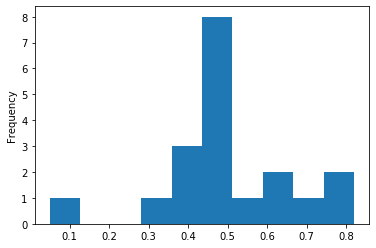

In [0]:
event_out['Sentiment_Score'].plot.hist()

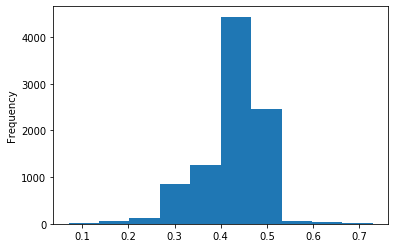

In [0]:
tweet_out['Sentiment_Score'].plot.hist()